[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Combined Sharpe: 1.84
Combined Max Drawdown: 9.74%


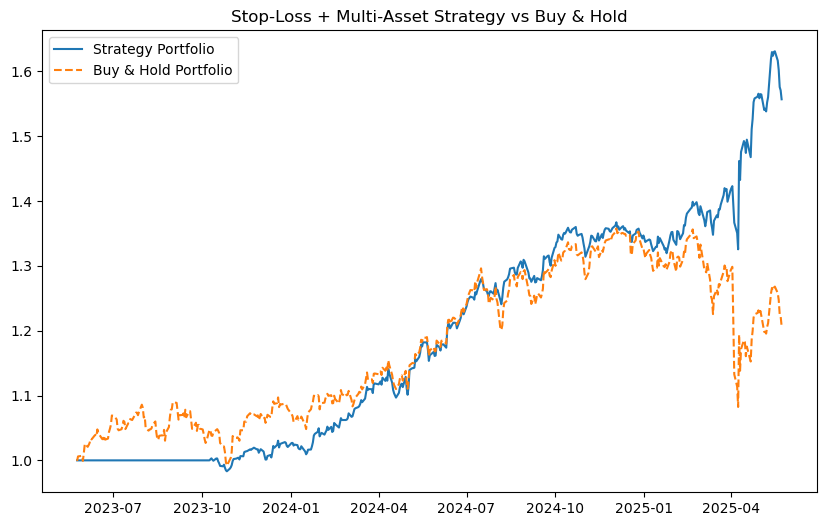

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. configuration
tickers   = ['AAPL', 'SPY', 'XOM']
stop_loss = 0.02       
rsi_low   = 40
rsi_high  = 75

# 2. Download data and calculate indicators
data_all = {}
for t in tickers:
    df = yf.download(t, period="2y", interval="1d").dropna()
    # RSI
    delta     = df['Close'].diff()
    gain      = delta.clip(lower=0)
    loss      = -delta.clip(upper=0)
    avg_gain  = gain.rolling(14).mean()
    avg_loss  = loss.rolling(14).mean()
    rs        = avg_gain / avg_loss
    df['RSI'] = 100 - 100/(1+rs)
    # MACD
    exp1        = df['Close'].ewm(span=12, adjust=False).mean()
    exp2        = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD']  = exp1 - exp2
    df['Signal']= df['MACD'].ewm(span=9, adjust=False).mean()
    data_all[t] = df

# 3. Generate signals and backtest each asset
rets = pd.DataFrame(index=data_all[tickers[0]].index)
for t, df in data_all.items():
    # Generate entry/exit signals
    df['Position'] = np.nan
    buy  = (df['RSI']  < rsi_low)  & (df['MACD'] > df['Signal'])
    sell = (df['RSI']  > rsi_high) & (df['MACD'] < df['Signal'])
    df.loc[buy,  'Position'] = 1
    df.loc[sell, 'Position'] = 0
    df['Position'] = df['Position'].ffill().fillna(0)

    # Calculate daily strategy returns and apply stop-loss
    ret = (df['Close'].pct_change()).squeeze() * df['Position'].shift()
    # If daily return < -stop_loss, cap it at -stop_loss
    ret = np.where(ret < -stop_loss, -stop_loss, ret)
    rets[t] = ret

# 4. Build equally-weighted portfolio returns
rets['Portfolio'] = rets.mean(axis=1)

# 5. Compute performance metrics
cumret = (1 + rets['Portfolio']).cumprod()
maxdd  = (cumret.cummax() - cumret).max()
sharpe = rets['Portfolio'].mean() / rets['Portfolio'].std() * np.sqrt(252)

print(f"Combined Sharpe: {sharpe:.2f}")
print(f"Combined Max Drawdown: {maxdd:.2%}")

# 6. Compare through visualization
plt.figure(figsize=(10,6))

# Plot the strategy portfolio cumulative return
plt.plot(cumret,label='Strategy Portfolio')

# Compute and plot the buy & hold portfolio
bh = pd.concat({t: (1+data_all[t]['Close'].pct_change()).cumprod() for t in tickers},axis=1)
bh_port = bh.mean(axis=1)
plt.plot(bh_port, '--', label='Buy & Hold Portfolio')
plt.title('Stop-Loss + Multi-Asset Strategy vs Buy & Hold')
plt.legend()
plt.show()
